In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread


# Set random seed for reproducibility
np.random.seed(42)
import random
import math

# Set Python and math random seeds
random.seed(42)
math.seed = 42

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns

correspondence = pd.read_csv('/lab/solexa_sun/lab_members/yancui/Haruka/protein_gene_conversion.csv')
correspondence.head()

import scanpy as sc 

rna_adata = sc.read_h5ad('/lab/solexa_sun/lab_members/yancui/Haruka/mela_rna_post.h5ad')

protein_adata = sc.read_h5ad('/lab/solexa_sun/lab_members/yancui/Haruka/mela_protein_post.h5ad')


rna_adata = rna_adata[rna_adata.obs['Study_name'] == 'Tirosh'].copy()

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rna_adata.var_names = rna_adata.var['feature_name'].apply(lambda x: x.split('_')[0]).astype(str).values

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            #print(r)
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)


# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()


# process rna_shared

sc.pp.filter_genes(rna_shared, min_counts=10)
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)


sc.pp.normalize_total(protein_shared)
sc.pp.scale(protein_shared)

rna_active = rna_adata.copy()

sc.pp.normalize_total(rna_active)
sc.pp.log1p(rna_active)
sc.pp.highly_variable_genes(rna_active, n_top_genes=5000)
# only retain highly variable genes
rna_active = rna_active[:, rna_active.var.highly_variable].copy()
sc.pp.scale(rna_active)

sc.pp.normalize_total(protein_adata)
sc.pp.scale(protein_adata)

# make sure no feature is static
rna_active = rna_active.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

rna_shared = rna_shared.X.copy()
protein_shared = protein_shared.X.copy()

/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells 

In [3]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None,
)

fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True,
    seed=42,
)

fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=15,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between thenleiden_seed
    resolution_tol=0.1,
    verbose=True,
    leiden_seed=42
)

fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=25, svd_components2=20
)

fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)


fusor.filter_bad_matches(target='pivot', filter_prop=0.5)

fusor.propagate(
    svd_components1=40, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

full_matching = fusor.get_matching(order=(1, 2), target='full_data')



related_rna = rna_adata[np.array(full_matching[0])][np.array(full_matching[2]) > 0.4]

control_adata =  rna_adata[~rna_adata.obs_names.isin(related_rna.obs_names)].copy()

full_adata = ad.concat([related_rna, control_adata], keys=['related', 'control'], label='related')

full_adata = full_adata[(full_adata.obs['cell_type'] == 'CD8-positive, alpha-beta T cell')].copy()


sc.pp.normalize_total(full_adata)

sc.pp.log1p(full_adata)

sc.tl.rank_genes_groups(full_adata, groupby='related', method='wilcoxon')



The first data is split into 1 batches, average batch size is 1124, and max batch size is 1124.
The second data is split into 9 batches, average batch size is 33534, and max batch size is 33537.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '0<->6', '0<->7', '0<->8'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 1...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 2...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 3...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 4...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 5...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 6...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 7...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Now at batch 8...


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Now at batch 6...
Now at batch 7...
Now at batch 8...
Graph clustering finished!
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Done!
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Done!
Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
2529/5058 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
109

In [6]:
(protein_adata[np.array(full_matching[1])].obs['Overall_Cell_Type'].value_counts())

Overall_Cell_Type
Epithelial    448
Tumor         300
Immune        176
Stromal       170
Name: count, dtype: int64

In [7]:
rna_adata.obs['cell_type']

cy88_cd45pos_5_C01_S217_comb                                 CD4-positive, alpha-beta T cell
cy74_CD45_pos_A12_S684_comb                                  CD8-positive, alpha-beta T cell
CY58_1_CD45_B02_S974_comb                                    CD8-positive, alpha-beta T cell
cy72_CD45_pos_H11_S959_comb                                  CD4-positive, alpha-beta T cell
cy58_1_CD45_pos_D08_S620_comb                                CD8-positive, alpha-beta T cell
                                                                          ...               
Melanoma3_previous_Melanoma_cy78_CD45_neg_1_H12_S576_comb                     malignant cell
Melanoma3_previous_Melanoma_CY88_3_C09_S609_comb                              malignant cell
Melanoma3_previous_Melanoma_cy78_CD45_neg_2_B07_S595_comb                     malignant cell
Melanoma3_previous_Melanoma_CY88_5_H02_S758_comb                              malignant cell
Melanoma3_previous_Melanoma_CY88_3_C02_S602_comb                      

In [8]:

index = (protein_adata[np.array(full_matching[1])].obs['Overall_Cell_Type'] == 'Immune').values

related_rna = rna_adata[np.array(full_matching[0])][index][np.array(full_matching[2])[index] > 0.4]

control_adata =  rna_adata[~rna_adata.obs_names.isin(related_rna.obs_names)].copy()

full_adata = ad.concat([related_rna, control_adata], keys=['related', 'control'], label='related')

full_adata = full_adata[full_adata.obs['cell_type'].isin(['T cell', 'macrophage', 'B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell'])].copy()

sc.pp.normalize_total(full_adata)

sc.pp.log1p(full_adata)

sc.tl.rank_genes_groups(full_adata, groupby='related', method='wilcoxon')


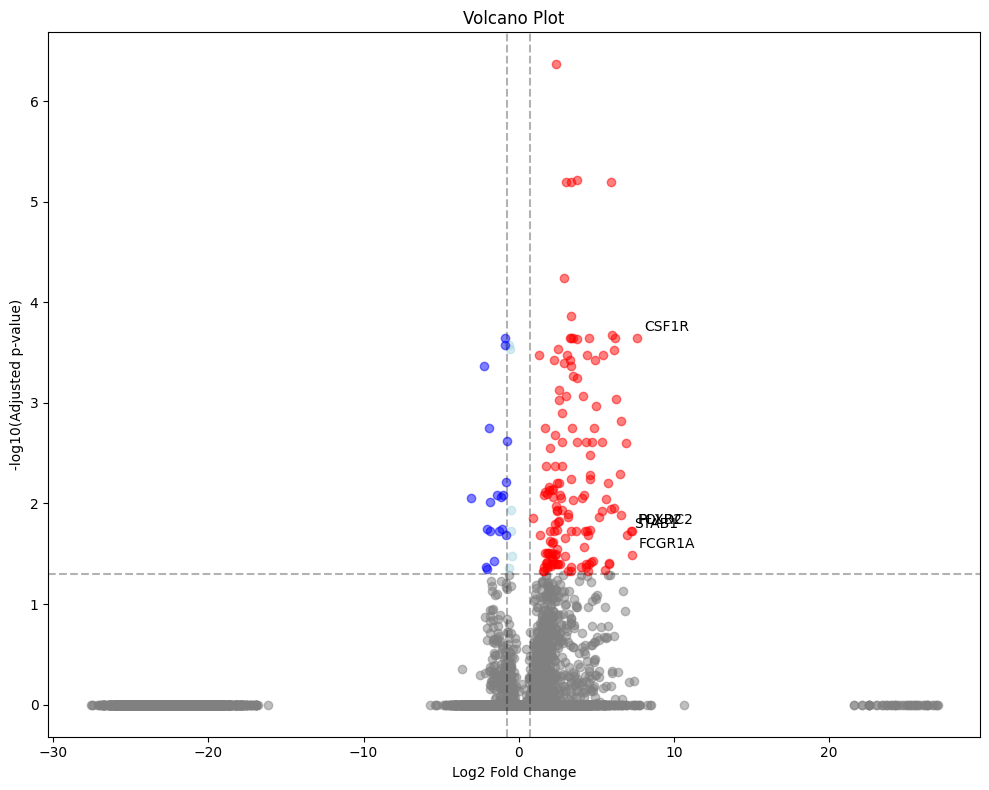

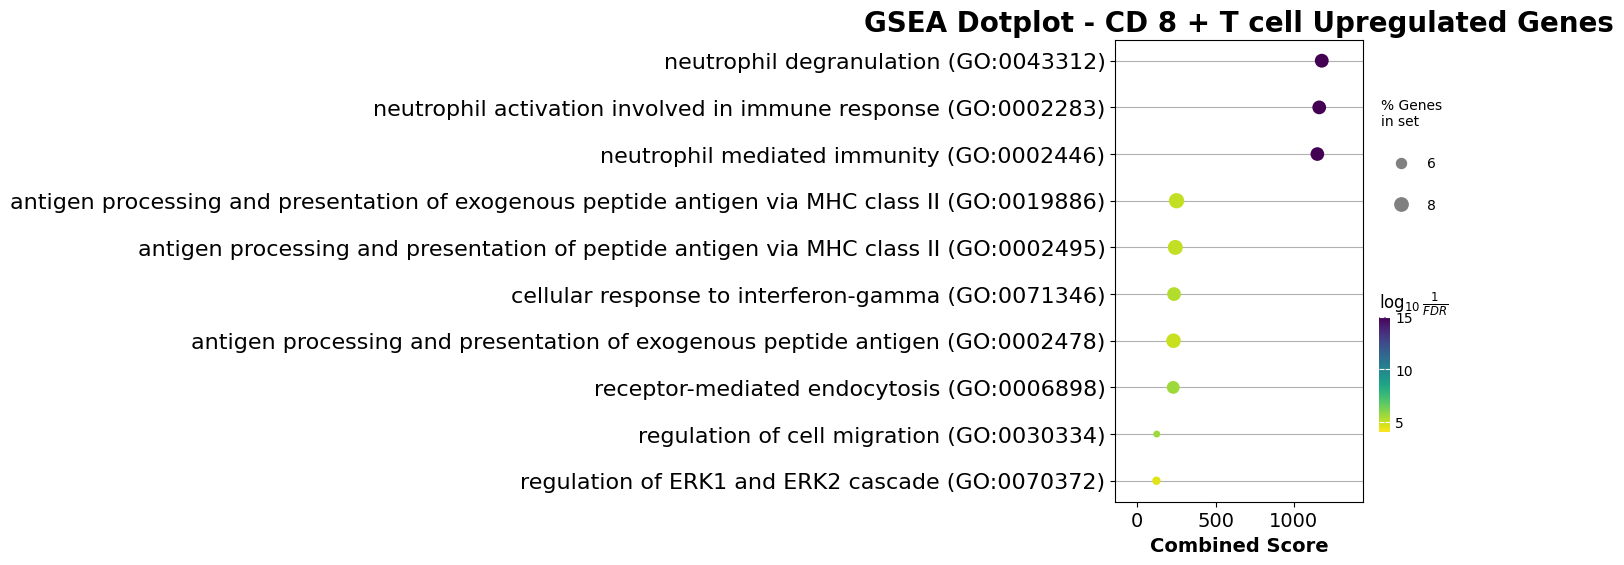

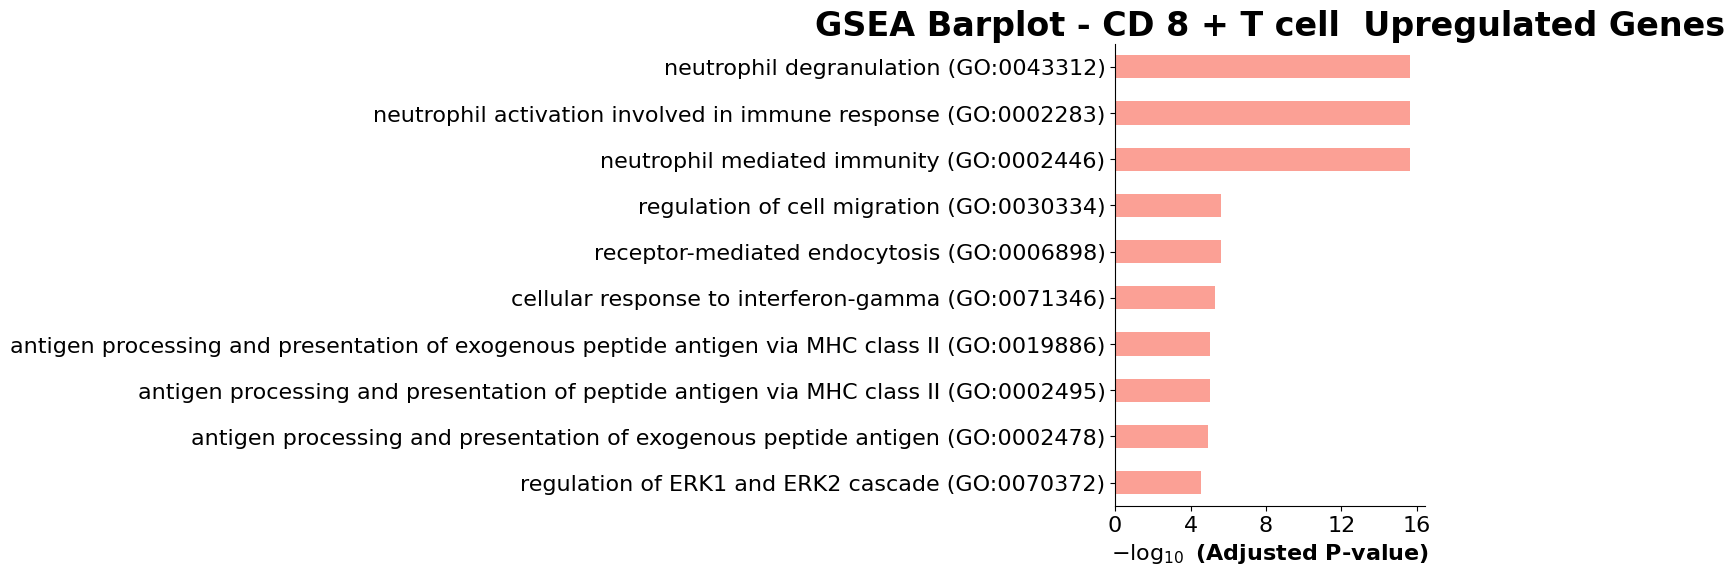

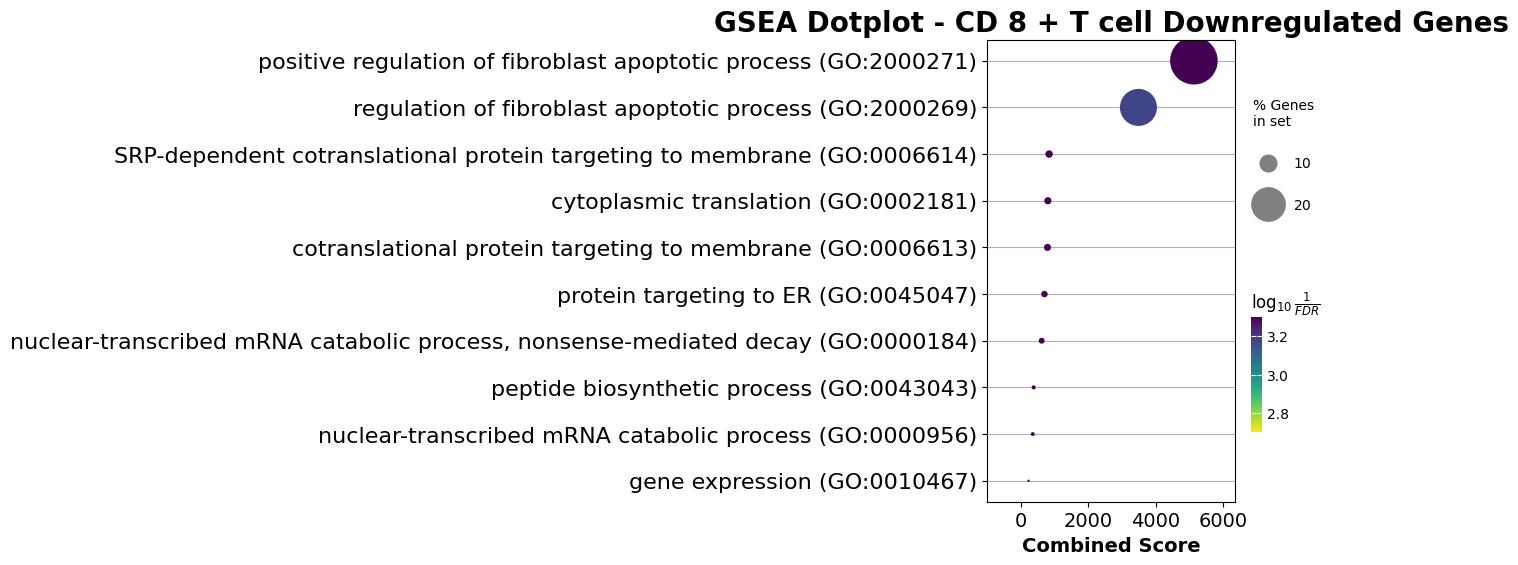

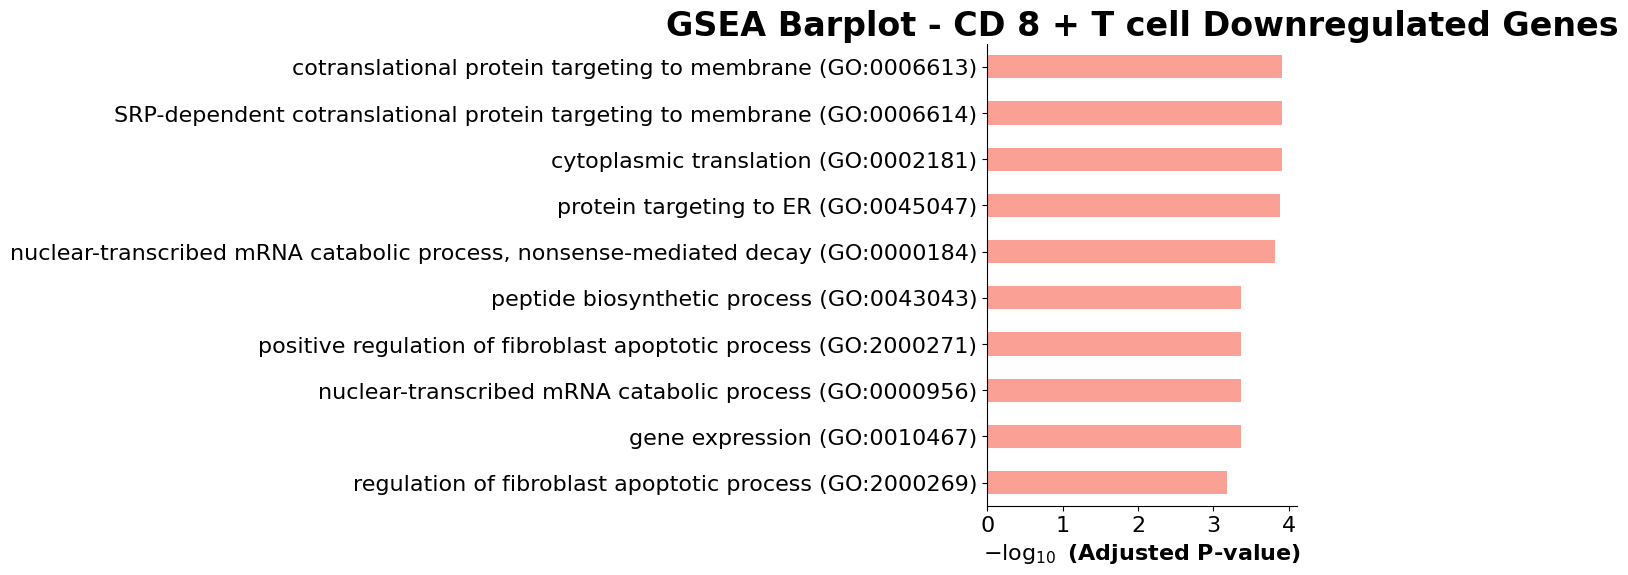

In [ ]:
# Get results from rank_genes_groups and create dataframe
import anndata as ad 
import scanpy as sc 
import numpy as np



result = sc.get.rank_genes_groups_df(full_adata, group='related')

# Create volcano plot using matplotlib
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10, 8))

# Plot non-significant points in gray
non_significant = result['pvals_adj'] >= 0.05
plt.scatter(result.loc[non_significant, 'logfoldchanges'],
        -np.log10(result.loc[non_significant, 'pvals_adj']),
        color='gray',
        alpha=0.5)

# Plot significant points with |logFC| < 1 in light colors
significant = result['pvals_adj'] < 0.05
low_fc_up = (result['logfoldchanges'] < 0.75) & (result['logfoldchanges'] > 0) & significant
low_fc_down = (result['logfoldchanges'] > -0.75) & (result['logfoldchanges'] < 0) & significant
plt.scatter(result.loc[low_fc_up, 'logfoldchanges'],
        -np.log10(result.loc[low_fc_up, 'pvals_adj']),
        color='pink',
        alpha=0.5)
plt.scatter(result.loc[low_fc_down, 'logfoldchanges'],
        -np.log10(result.loc[low_fc_down, 'pvals_adj']),
        color='lightblue',
        alpha=0.5)

# Plot significant points with |logFC| >= 1 in dark colors
high_fc_up = (result['logfoldchanges'] >= 0.75) & significant
high_fc_down = (result['logfoldchanges'] <= -0.75) & significant
plt.scatter(result.loc[high_fc_up, 'logfoldchanges'],
        -np.log10(result.loc[high_fc_up, 'pvals_adj']),
        color='red',
        alpha=0.5)
plt.scatter(result.loc[high_fc_down, 'logfoldchanges'],
        -np.log10(result.loc[high_fc_down, 'pvals_adj']),
        color='blue',
        alpha=0.5)

# Get top 5 genes by absolute fold change among significant genes
result['abs_logfc'] = abs(result['logfoldchanges'])
top_genes = result[significant].nlargest(5, 'abs_logfc')

# Add labels for top genes
for _, gene in top_genes.iterrows():
    plt.annotate(gene['names'],
                xy=(gene['logfoldchanges'], -np.log10(gene['pvals_adj'])),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10)

# Add labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Adjusted p-value)')
plt.title('Volcano Plot')

# Add horizontal line for p-value cutoff
plt.axhline(y=-np.log10(0.05), color='k', linestyle='--', alpha=0.3)
# Add vertical lines for fold change cutoffs
plt.axvline(x=0.75, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=-0.75, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Get upregulated and downregulated gene sets
significant_genes = result[result['pvals_adj'] < 0.05]
up_genes = significant_genes[significant_genes['logfoldchanges'] > 0.75]['names'].tolist()
down_genes = significant_genes[significant_genes['logfoldchanges'] < -0.75]['names'].tolist()

# Run enrichr analysis for both gene sets
import gseapy as gp

try:

    # Upregulated genes
    enr_up = gp.enrichr(gene_list=up_genes,
                        organism='Human',
                        gene_sets=['GO_Biological_Process_2021'])

    gp.dotplot(enr_up.res2d, title=f'GSEA Dotplot - CD 8 + T cell Upregulated Genes',
            cutoff=0.1,
            color_bar_label='Normalized Enrichment Score (NES)',
            size=20)

    gp.barplot(enr_up.res2d, title=f'GSEA Barplot - CD 8 + T cell  Upregulated Genes',
            cutoff=0.1,
            color_bar_label='Normalized Enrichment Score (NES)')


except:
    pass

try:
    # Downregulated genes
    enr_down = gp.enrichr(gene_list=down_genes,
                        organism='Human', 
                        gene_sets=['GO_Biological_Process_2021'])

    gp.dotplot(enr_down.res2d, title=f'GSEA Dotplot - CD 8 + T cell Downregulated Genes',
            cutoff=0.1,
            color_bar_label='Normalized Enrichment Score (NES)',
            size=20).figure

    gp.barplot(enr_down.res2d, title=f'GSEA Barplot - CD 8 + T cell Downregulated Genes',
            cutoff=0.1,
            color_bar_label='Normalized Enrichment Score (NES)')

except:
    pass

In [11]:
rna_match  = rna_adata.copy()

sc.pp.normalize_total(rna_match)
sc.pp.log1p(rna_match)

In [12]:


related_rna = rna_adata[np.array(full_matching[0])][index][np.array(full_matching[2])[index] > 0.4]

control_adata =  rna_adata[~rna_adata.obs_names.isin(related_rna.obs_names)].copy()

full_adata = ad.concat([related_rna, control_adata], keys=['related', 'control'], label='related')



In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr

# Filter matching by score threshold
mask = np.array(full_matching[2])[index] > 0.4
matched_indices_rna = np.array(full_matching[0])[index][mask].astype(int)
matched_indices_protein = np.array(full_matching[1])[index][mask].astype(int)

# Extract expression matrices using only significant genes
rna_match_filtered = rna_match[matched_indices_rna]
protein_adata_filtered = protein_adata[matched_indices_protein]
protein_adata_filtered = protein_adata_filtered[rna_match_filtered.obs['cell_type'].isin(['T cell', 'macrophage', 'B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell'])]
rna_match_filtered = rna_match_filtered[rna_match_filtered.obs['cell_type'].isin(['T cell', 'macrophage', 'B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell'])]


# Get expression matrices - use only significant genes for RNA
significant_genes = result[(result['pvals_adj'] < 0.05) & (result['logfoldchanges'] > 0.75)] ['names'].tolist()
rna_match_filtered = rna_match_filtered[:, rna_match_filtered.var_names.isin(significant_genes)]

rna_expr = rna_match_filtered.X.toarray()
protein_expr = protein_adata_filtered[:, (protein_adata_filtered.var_names != 'DAPI') & (protein_adata_filtered.var_names != 'CXCL13')].X

# Calculate correlations between all proteins and significant RNAs
correlations = []
for i, protein_name in enumerate(tqdm(protein_adata_filtered.var_names[(protein_adata_filtered.var_names != 'DAPI') & (protein_adata_filtered.var_names != 'CXCL13')])):
    for j, rna_name in enumerate(rna_match_filtered.var_names):
        corr, pval = pearsonr(protein_expr[:, i], rna_expr[:, j])
        correlations.append({
            'Protein': protein_name,
            'RNA': rna_name,
            'Correlation': corr,
            'P_value': pval,
            'Abs_Correlation': abs(corr)
        })

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations)
top_pairs = corr_df.sort_values('Abs_Correlation', ascending=False).head(20)

print("\nTop 20 correlated protein-RNA pairs (using significant genes only):")
print(top_pairs[['Protein', 'RNA', 'Correlation', 'P_value']])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 52.86it/s]


Top 20 correlated protein-RNA pairs (using significant genes only):
     Protein       RNA  Correlation   P_value
6147    MMP9      FTH1    -0.558780  0.000025
946    CD163  HLA-DQB2     0.495972  0.000250
2741    CD57      SRGN    -0.471325  0.000551
1146    CD20      SRGN    -0.421344  0.002310
4626   FoxP3      SRGN    -0.412539  0.002909
2751    CD57      GPX1    -0.409157  0.003174
329    CD11b      CD74    -0.401531  0.003851
940    CD163     ITGAX     0.392954  0.004760
6191    MMP9      PSAP    -0.383912  0.005917
2723    CD57      SGK1    -0.383662  0.005952
2613    CD57     ANXA5    -0.380804  0.006368
1236   CD206  HLA-DQB2     0.377566  0.006869
6215    MMP9    TMSB10    -0.373743  0.007505
2640    CD57     FCGRT    -0.371311  0.007935
3181     CD8      ZEB2     0.371274  0.007942
2644    CD57      CTSD    -0.366918  0.008767
6217    MMP9      TPI1    -0.365472  0.009057
2732    CD57     PEA15    -0.362818  0.009611
4771   GATA3      SRGN    -0.354125  0.011634
1013   CD16

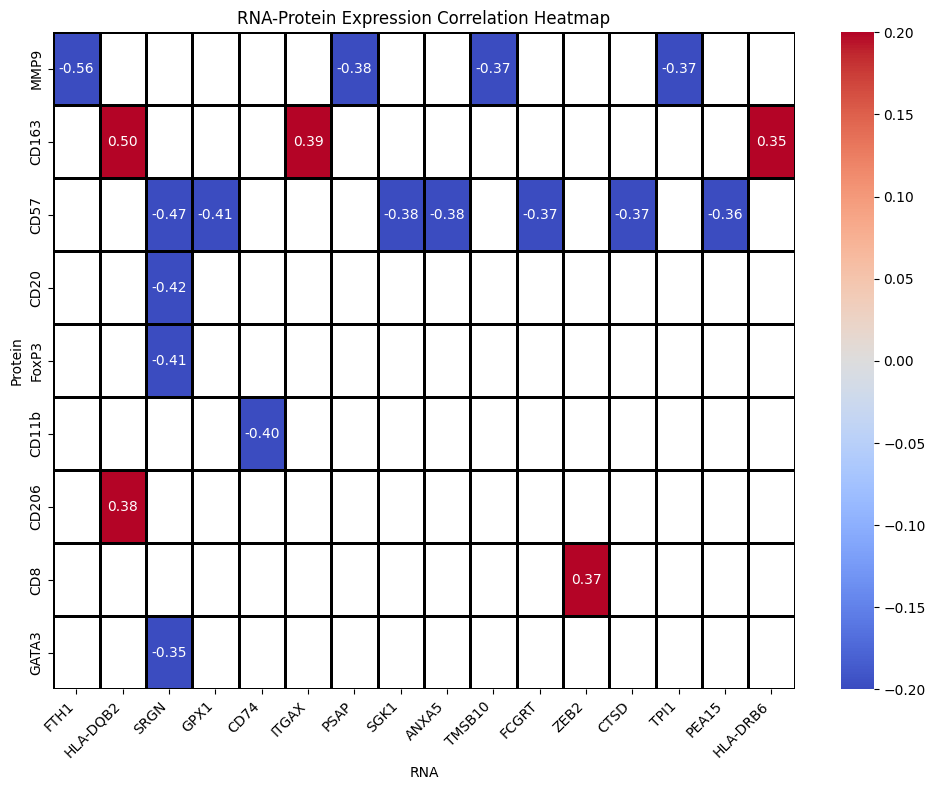

In [ ]:
# Get unique RNA and protein genes from top 20 pairs
unique_rnas = top_pairs['RNA'].unique()
unique_proteins = top_pairs['Protein'].unique()

# Create correlation matrix
corr_matrix = np.zeros((len(unique_proteins), len(unique_rnas)))

# Fill correlation matrix
for i, protein in enumerate(unique_proteins):
    for j, rna in enumerate(unique_rnas):
        # Find correlation value from corr_df if it exists
        corr_value = corr_df[(corr_df['Protein'] == protein) & 
                            (corr_df['RNA'] == rna)]['Correlation'].values
        if len(corr_value) > 0:
            corr_matrix[i,j] = corr_value[0]

# Create mask for top 20 pairs
mask = np.ones_like(corr_matrix)
for _, row in top_pairs.iterrows():
    i = np.where(unique_proteins == row['Protein'])[0][0]
    j = np.where(unique_rnas == row['RNA'])[0][0]
    mask[i,j] = 0

# Create heatmap
plt.figure(figsize=(10, 8))

# Get RNA regulation status from result dataframe
rna_colors = []
for rna in unique_rnas:
    rna_row = result[result['names'] == rna]
    if len(rna_row) > 0:
        if rna_row['logfoldchanges'].values[0] > 0:
            rna_colors.append('orange')  # Upregulated
        else:
            rna_colors.append('green')   # Downregulated
    else:
        rna_colors.append('black')  # Default color if not found

sns.heatmap(corr_matrix,
            xticklabels=unique_rnas,
            yticklabels=unique_proteins,
            cmap='coolwarm',
            center=0,
            vmin=-0.2,
            vmax=0.2,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='black',
            mask=mask)

# Color the RNA labels based on regulation
ax = plt.gca()
ax.xaxis.set_tick_params(colors='black')


plt.title('RNA-Protein Expression Correlation Heatmap')
plt.xlabel('RNA')
plt.ylabel('Protein')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/maxfuse_repo_envi/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/tmp/ipykernel_1103090/1046901890.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pyda

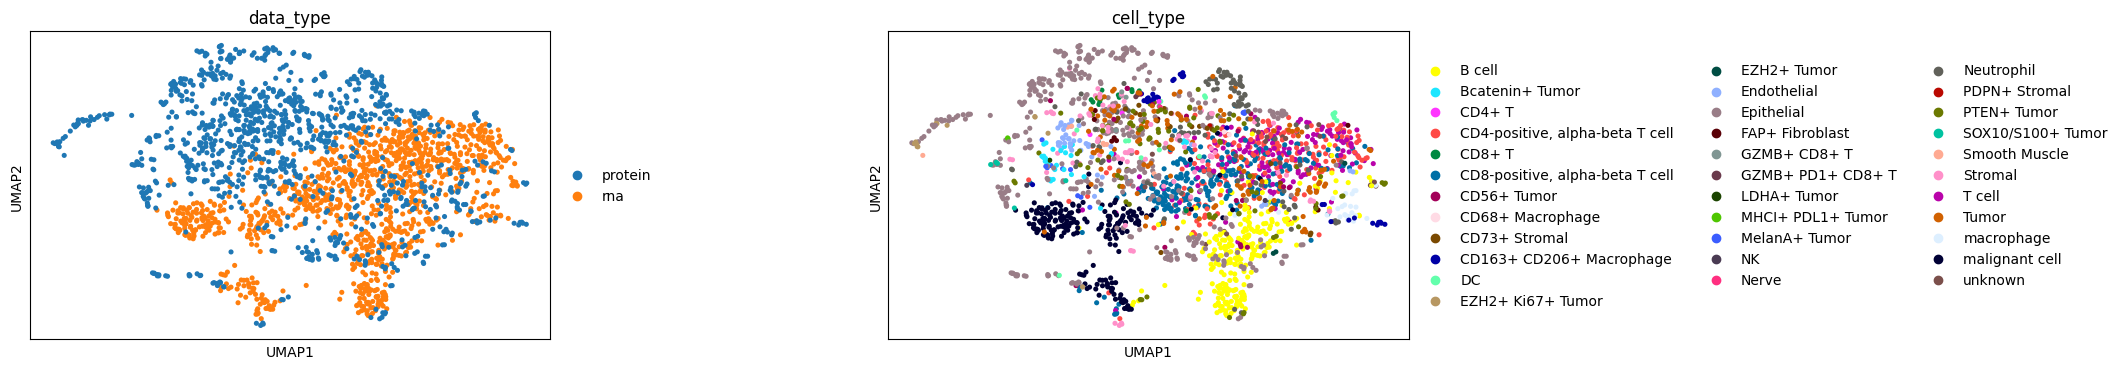

In [ ]:

rna_cca, protein_cca_sub = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2[full_matching[1],:] # cells in codex remained after filtering
)

np.random.seed(42)


dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca_sub[:,:dim_use]), axis=0), 
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca_sub.shape[0]
cca_adata.obs['cell_type'] = list(np.concatenate((rna_adata.obs['cell_type'].values,
                                                  protein_adata.obs['Cell_Type'].values[full_matching[1]]), axis = 0))

cca_adata.obs['cell_type'].loc[cca_adata.obs['cell_type'] == 'B'] = 'B cell'

sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)

#sc.pl.umap(cca_adata, color=['data_type', 'cell_type'], wspace=0.5)
sc.pl.umap(cca_adata, color=['data_type', 'cell_type'], wspace=0.5)
